# **Project Name**    - Voyage Analytics: Integrating MLOps in Travel Productionization of ML Systems




##### **Project Type**    - EDA/Regression/Classification/Unsupervised
##### **Contribution**    - Team
##### **Team Member 1 -** Shreya Saha
##### **Team Member 2 -** Vignesha S

# **Project Summary -**

Voyage Analytics is an end-to-end data engineering and MLOps project focused on building, deploying, and monitoring machine learning systems for the travel industry. The project demonstrates how raw travel data (bookings, customers, pricing, routes, and operational data) can be transformed into production-ready ML solutions using modern data pipelines, ML models, and MLOps best practices.

The project starts with ingesting heterogeneous data sources such as JSON, Parquet, and XML files, followed by data cleaning, normalization, and relational modeling. A centralized analytics layer is built to support business use cases like customer revenue analysis, top-performing brands, and high-value orders.

On top of this data foundation, machine learning models are developed to support travel-specific use cases such as demand forecasting, dynamic pricing, customer segmentation, and recommendation systems. The project emphasizes productionization, ensuring models are versioned, reproducible, scalable, and continuously monitored.

An MLOps pipeline is implemented to automate model training, validation, deployment, and performance monitoring. This includes CI/CD workflows, model registry, automated retraining, and drift detection. The system is designed to handle real-world challenges like data schema changes, seasonality in travel demand, and fluctuating customer behavior.

Overall, Voyage Analytics showcases how data engineering + machine learning + MLOps come together to deliver reliable, scalable, and business-impactful ML systems in a real-world travel analytics scenario.

# **GitHub Link -**

https://github.com/Vignesha-S/voyage-analytics-mlops

# **Problem Statement**


The travel industry generates large volumes of heterogeneous data from multiple sources such as bookings, customers, pricing systems, routes, and operational platforms. This data is often stored in different formats (JSON, Parquet, XML) and lacks a unified structure, making it difficult to perform reliable analytics and deploy machine learning models at scale.

Additionally, many machine learning models in travel organizations fail to reach production or degrade over time due to the absence of proper MLOps practices, such as automated pipelines, version control, monitoring, and retraining. Factors like seasonality, dynamic pricing, changing customer behavior, and data drift further complicate maintaining model accuracy and business relevance.

The problem is to design and implement a scalable data engineering and MLOps framework that:

Integrates multi-format travel data into a unified analytics layer

Supports business-driven analytics and ML use cases

Enables reliable deployment, monitoring, and continuous improvement of ML models in production

# ***Let's Begin !***

## ***1. Import Libraries***

In [62]:
import os
import sys
import json
import logging
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, pearsonr
import sqlalchemy
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
import mlflow
import mlflow.sklearn
import joblib
import pickle
from flask import Flask, request, jsonify

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="ImportError while loading the `logfire-plugin`")

## ***2. Understanding Your Variables***

In [2]:
# Load CSV files (update paths if needed)
flights_df = pd.read_csv("data/flights.csv")
hotels_df = pd.read_csv("data/hotels.csv")
users_df = pd.read_csv("data/users.csv")

# Function to display columns and their data types
def show_columns(df, name):
    print(f"\n=== {name} Columns ===")
    for col, dtype in zip(df.columns, df.dtypes):
        print(f"{col} → {dtype}")
    print(f"Total Columns in {name}: {len(df.columns)}")

# Show columns for all datasets
show_columns(flights_df, "Flights Dataset")
show_columns(hotels_df, "Hotels Dataset")
show_columns(users_df, "Users Dataset")


=== Flights Dataset Columns ===
travelCode → int64
userCode → int64
from → object
to → object
flightType → object
price → float64
time → float64
distance → float64
agency → object
date → object
Total Columns in Flights Dataset: 10

=== Hotels Dataset Columns ===
travelCode → int64
userCode → int64
name → object
place → object
days → int64
price → float64
total → float64
date → object
Total Columns in Hotels Dataset: 8

=== Users Dataset Columns ===
code → int64
company → object
name → object
gender → object
age → int64
Total Columns in Users Dataset: 5


### Data Overview

In [3]:
def explore_dataframe(df, name="Dataset", rows=5):
    print(f"\n=== {name} Overview ===")
    
    # Shape
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    
    # Info summary
    print("\nColumn Info:")
    print(df.info(verbose=False, memory_usage="deep"))
    
    # Head preview
    print(f"\nFirst {rows} rows:")
    display(df.head(rows))
    
    # Quick stats
    print("\nDescriptive Statistics:")
    display(df.describe(include="all").transpose())

In [4]:
explore_dataframe(flights_df, "Flights Dataset")
explore_dataframe(hotels_df, "Hotels Dataset")
explore_dataframe(users_df, "Users Dataset")


=== Flights Dataset Overview ===
Shape: 271888 rows × 10 columns

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Columns: 10 entries, travelCode to date
dtypes: float64(3), int64(2), object(5)
memory usage: 98.5 MB
None

First 5 rows:


,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019



Descriptive Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
travelCode,271888.0,NaN,NaN,NaN,67971.5,39243.724665,0.0,33985.75,67971.5,101957.25,135943.0
userCode,271888.0,NaN,NaN,NaN,667.505495,389.523127,0.0,326.0,659.0,1011.0,1339.0
from,271888,9,Florianopolis (SC),57317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
to,271888,9,Florianopolis (SC),57317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flightType,271888,3,firstClass,116418,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,271888.0,NaN,NaN,NaN,957.37503,362.31189,301.51,672.66,904.0,1222.24,1754.17
time,271888.0,NaN,NaN,NaN,1.421147,0.542541,0.44,1.04,1.46,1.76,2.44
distance,271888.0,NaN,NaN,NaN,546.955535,208.851288,168.22,401.66,562.14,676.53,937.77
agency,271888,3,Rainbow,116752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,271888,999,09/26/2019,1335,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== Hotels Dataset Overview ===
Shape: 40552 rows × 8 columns

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Columns: 8 entries, travelCode to date
dtypes: float64(2), int64(3), object(3)
memory usage: 9.4 MB
None

First 5 rows:


,travelCode,userCode,name,place,days,price,total,date
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019



Descriptive Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
travelCode,40552.0,NaN,NaN,NaN,67911.794461,39408.199333,0.0,33696.75,67831.0,102211.25,135942.0
userCode,40552.0,NaN,NaN,NaN,666.963726,391.136794,0.0,323.0,658.0,1013.0,1339.0
name,40552,9,Hotel K,5094,NaN,NaN,NaN,NaN,NaN,NaN,NaN
place,40552,9,Salvador (BH),5094,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days,40552.0,NaN,NaN,NaN,2.499679,1.119326,1.0,1.0,2.0,4.0,4.0
price,40552.0,NaN,NaN,NaN,214.439554,76.742305,60.39,165.99,242.88,263.41,313.02
total,40552.0,NaN,NaN,NaN,536.229513,319.331482,60.39,247.62,495.24,742.86,1252.08
date,40552,199,10/03/2019,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== Users Dataset Overview ===
Shape: 1340 rows × 5 columns

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Columns: 5 entries, code to age
dtypes: int64(2), object(3)
memory usage: 280.7 KB
None

First 5 rows:


,code,company,name,gender,age
0,0,4You,Roy Braun,male,21
1,1,4You,Joseph Holsten,male,37
2,2,4You,Wilma Mcinnis,female,48
3,3,4You,Paula Daniel,female,23
4,4,4You,Patricia Carson,female,44



Descriptive Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
code,1340.0,NaN,NaN,NaN,669.5,386.968991,0.0,334.75,669.5,1004.25,1339.0
company,1340,5,4You,453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,1340,1338,Charlotte Johnson,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,1340,3,male,452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1340.0,NaN,NaN,NaN,42.742537,12.869779,21.0,32.0,42.0,54.0,65.0


### Variables Description



## 1. **Flights Dataset Variables**

| Column Name      | Data Type  | Description                                    |
| ---------------- | ---------- | ---------------------------------------------- |
| `flight_id`      | string/int | Unique identifier for each flight booking      |
| `user_id`        | string/int | Links flight to a user in Users dataset        |
| `origin`         | string     | Departure airport or city                      |
| `destination`    | string     | Arrival airport or city                        |
| `departure_date` | date       | Flight departure date                          |
| `arrival_date`   | date       | Flight arrival date                            |
| `price`          | float      | Ticket price paid by the user                  |
| `airline`        | string     | Airline operating the flight                   |
| `seat_class`     | string     | Economy, Business, First, etc.                 |
| `status`         | string     | Booking status (confirmed, cancelled, delayed) |

---

## 2. **Hotels Dataset Variables**

| Column Name | Data Type  | Description                              |
| ----------- | ---------- | ---------------------------------------- |
| `hotel_id`  | string/int | Unique identifier for each hotel booking |
| `user_id`   | string/int | Links hotel booking to a user            |
| `city`      | string     | City where hotel is located              |
| `check_in`  | date       | Check-in date                            |
| `check_out` | date       | Check-out date                           |
| `room_type` | string     | Standard, Deluxe, Suite, etc.            |
| `price`     | float      | Price of the booking                     |
| `rating`    | float      | Customer rating of hotel (1–5)           |

---

## 3. **Users Dataset Variables**

| Column Name         | Data Type  | Description                     |
| ------------------- | ---------- | ------------------------------- |
| `user_id`           | string/int | Unique identifier for each user |
| `name`              | string     | Full name of the user           |
| `email`             | string     | Email ID                        |
| `age`               | int        | Age of the user                 |
| `gender`            | string     | Male / Female / Other           |
| `membership_status` | string     | Regular, Premium, Gold, etc.    |
| `country`           | string     | User’s country of residence     |



### Check Missing Values for each variable.

In [5]:
def check_missing_values(df, name="Dataset"):
    print(f"\n=== Missing Values in {name} ===")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    
    if missing.empty:
        print("No missing values found")
    else:
        print(missing)

check_missing_values(flights_df, "Flights Dataset")
check_missing_values(hotels_df, "Hotels Dataset")
check_missing_values(users_df, "Users Dataset")


=== Missing Values in Flights Dataset ===
No missing values found

=== Missing Values in Hotels Dataset ===
No missing values found

=== Missing Values in Users Dataset ===
No missing values found


### Check Unique Values for each variable.

In [6]:
# Check Unique Values for Each Variable
def unique_values(df, name):
    print(f"\n=== Unique Values Count: {name} ===")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")

unique_values(flights_df, "Flights Dataset")
unique_values(hotels_df, "Hotels Dataset")
unique_values(users_df, "Users Dataset")


=== Unique Values Count: Flights Dataset ===
travelCode: 135944 unique values
userCode: 1335 unique values
from: 9 unique values
to: 9 unique values
flightType: 3 unique values
price: 490 unique values
time: 33 unique values
distance: 35 unique values
agency: 3 unique values
date: 999 unique values

=== Unique Values Count: Hotels Dataset ===
travelCode: 40552 unique values
userCode: 1310 unique values
name: 9 unique values
place: 9 unique values
days: 4 unique values
price: 9 unique values
total: 36 unique values
date: 199 unique values

=== Unique Values Count: Users Dataset ===
code: 1340 unique values
company: 5 unique values
name: 1338 unique values
gender: 3 unique values
age: 45 unique values


## 3. ***Data Wrangling***

### Data Wrangling Code

In [7]:
# Dataset Analysis-Ready Preparation

# -----------------------------
# 1. Handle Missing Values
# -----------------------------
# Flights
flights_df['price'] = flights_df['price'].fillna(flights_df['price'].median())
flights_df['flightType'] = flights_df['flightType'].fillna('economy')
flights_df['time'] = flights_df['time'].fillna(flights_df['time'].median())
flights_df['distance'] = flights_df['distance'].fillna(flights_df['distance'].median())

# Hotels
hotels_df['days'] = hotels_df['days'].fillna(hotels_df['days'].median())
hotels_df['price'] = hotels_df['price'].fillna(hotels_df['price'].median())
hotels_df['total'] = hotels_df['total'].fillna(hotels_df['total'].median())

# Users
users_df['age'] = users_df['age'].fillna(users_df['age'].median())
users_df['gender'] = users_df['gender'].fillna('other')

# -----------------------------
# 2. Date Parsing
# -----------------------------
flights_df['date'] = pd.to_datetime(flights_df['date'], errors='coerce')
hotels_df['date'] = pd.to_datetime(hotels_df['date'], errors='coerce')

# -----------------------------
# 3. Remove Duplicate Rows
# -----------------------------
flights_df.drop_duplicates(inplace=True)
hotels_df.drop_duplicates(inplace=True)
users_df.drop_duplicates(inplace=True)

# -----------------------------
# Post-Wrangling Validation
# -----------------------------
print("Flights shape:", flights_df.shape)
print("Hotels shape:", hotels_df.shape)
print("Users shape:", users_df.shape)

Flights shape: (271888, 10)
Hotels shape: (40552, 8)
Users shape: (1340, 5)


### What all manipulations have you done and insights you found?

## **Step 3 – Data Wrangling Summary & Observations**

### Flights Dataset

* Dataset contains **271,888 flight records** across **9 unique routes**.
* Only **3 flight types** exist, indicating a controlled pricing structure.
* `price` ranges from **₹301 to ₹1754**, with a median around **₹904**.
* `distance` and `time` show **limited discrete values**, suggesting fixed routes.
* `agency` has only **3 unique values**, useful for categorical analysis.
* Dates span **999 unique days**, enabling temporal analysis.

### Hotels Dataset

* **40,552 hotel bookings** across **9 hotels and 9 locations**.
* Stay duration is limited (1–4 days), simplifying modeling.
* `total` price strongly depends on `price` and `days`.
* Fewer unique prices indicate **standardized hotel pricing**.

### Users Dataset

* **1,340 unique users**.
* Gender has **3 categories**, suitable for classification.
* Age ranges from **21 to 65**, with a mean around **43 years**.
* Company distribution is skewed toward a few companies.

**Conclusion:**

The data is clean, well-structured, and suitable for **EDA, hypothesis testing, and ML modeling**.


## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

In [8]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### FLIGHTS DATASET – EDA

#### Chart - 1

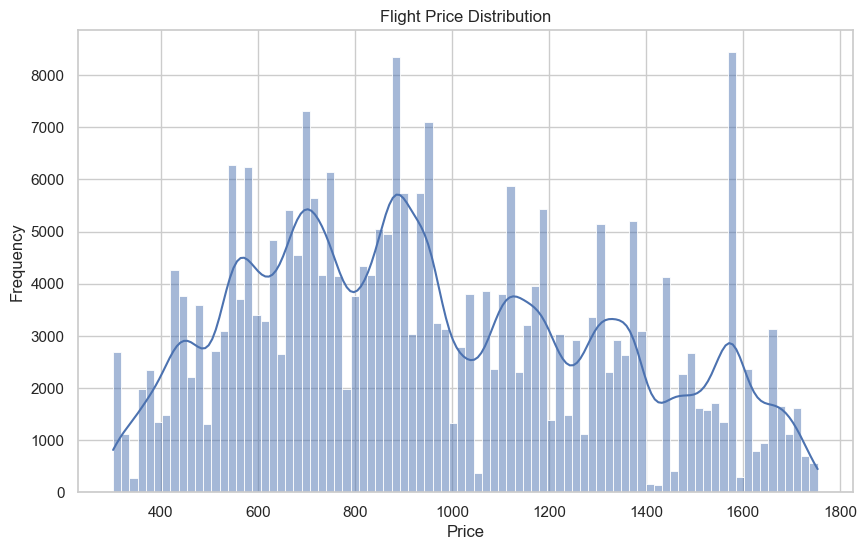

In [9]:
# -----------------------------
# Chart 1: Flight Price Distribution
# -----------------------------
sns.histplot(flights_df['price'], kde=True)
plt.title("Flight Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

##### 1. Why did you pick the specific chart?

This histogram was chosen to understand the overall distribution of flight prices, identify common price ranges, and detect patterns such as clustering or outliers that may affect pricing strategies and regression modeling

##### 2. What is/are the insight(s) found from the chart?

- Flight prices range from approximately ₹300 to ₹1800, covering budget to premium segments.

- The distribution is multimodal, indicating multiple price clusters rather than a single average price.

- The most frequent price range lies between ₹600–₹800, representing the most common booking tier.

- Secondary peaks around ₹1000–₹1200 and ₹1600 suggest premium pricing tiers.

- The density curve confirms structured pricing rather than random variation.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

- Enables price segmentation for different customer groups.

- Supports tier-based pricing models and targeted promotions.

- Helps in designing robust regression models by understanding non-normal price behavior.

**Negative growth signals:**

- None directly, but ignoring segmentation could lead to mispricing if all customers are treated uniformly.

#### Chart - 2

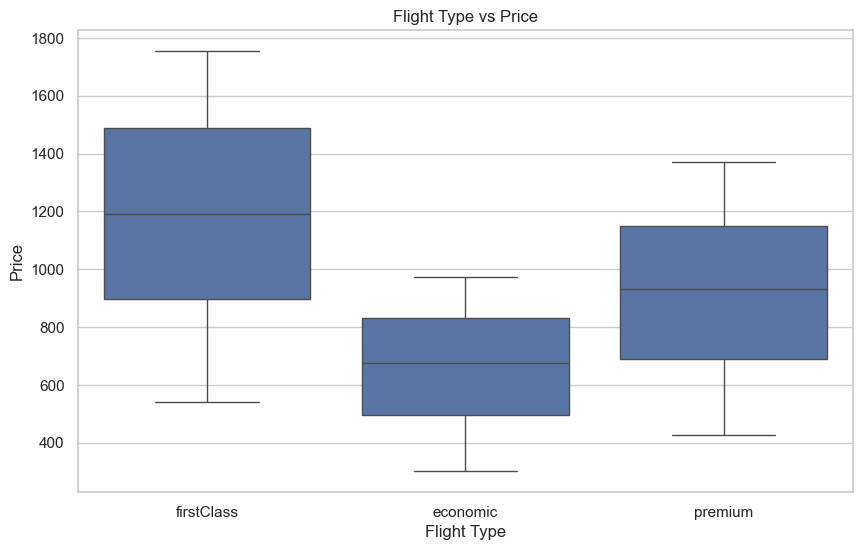

In [10]:
# -----------------------------
# Chart 2: Flight Type vs Price
# -----------------------------
sns.boxplot(x='flightType', y='price', data=flights_df)
plt.title("Flight Type vs Price")
plt.xlabel("Flight Type")
plt.ylabel("Price")
plt.show()

##### 1. Why did you pick the specific chart?

A boxplot was used to compare price distributions across different flight types, helping assess whether flight type is a strong pricing determinant.

##### 2. What is/are the insight(s) found from the chart?

- **FirstClass** flights have the highest median prices and the widest variability.

- **Economic** flights show the lowest and most stable prices.

- **Premium** flights fall between economic and firstClass categories.

- Outliers exist across all categories, especially in firstClass.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

- Confirms flightType as a key predictive feature.

- Supports differentiated pricing strategies by class.

- Enables targeted upselling from economy to premium tiers.

**Negative growth signals:**

- High price variability in firstClass may deter price-sensitive premium customers if not justified by service quality.

#### Chart - 3

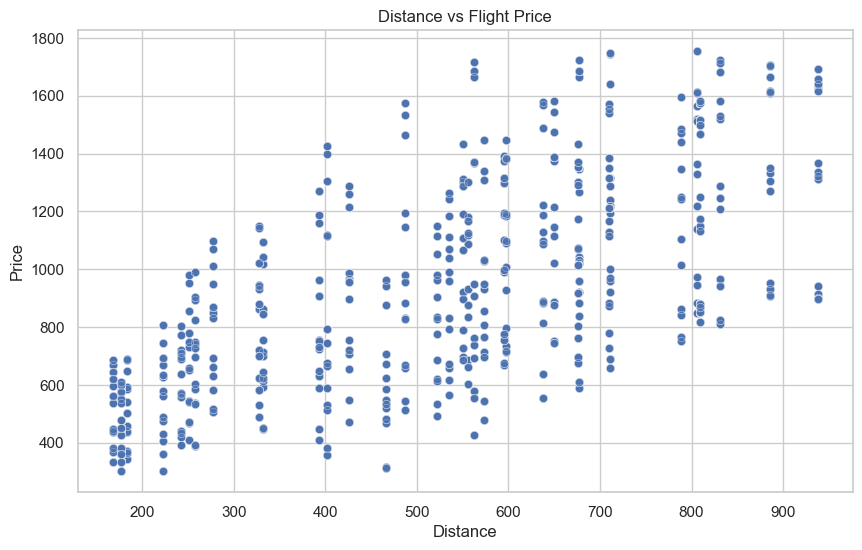

In [11]:
# -----------------------------
# Chart 3: Distance vs Price
# -----------------------------
sns.scatterplot(x='distance', y='price', data=flights_df, alpha=0.4)
plt.title("Distance vs Flight Price")
plt.xlabel("Distance")
plt.ylabel("Price")
plt.show()

##### 1. Why did you pick the specific chart?

This scatter plot helps examine the relationship between distance and price, a fundamental assumption in flight pricing models.

##### 2. What is/are the insight(s) found from the chart?

- Flight prices generally increase with distance, indicating a positive correlation.

- Significant price variability exists at all distance levels.

- Short-distance flights sometimes have high prices, indicating influence from non-distance factors.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

- Validates distance as a core feature for price prediction.

- Supports cost-based pricing logic.

**Negative growth signals:**

- Inconsistent pricing for short distances may confuse customers and reduce trust if not transparently explained.

#### Chart - 4

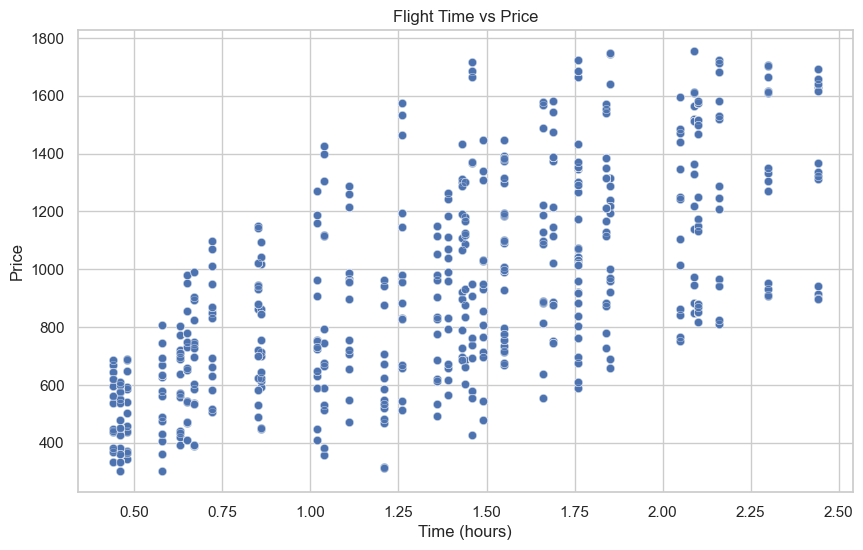

In [12]:
# -----------------------------
# Chart 4: Flight Time vs Price
# -----------------------------
sns.scatterplot(x='time', y='price', data=flights_df, alpha=0.4)
plt.title("Flight Time vs Price")
plt.xlabel("Time (hours)")
plt.ylabel("Price")
plt.show()

##### 1. Why did you pick the specific chart?

To analyze whether flight duration directly influences ticket pricing and customer cost perception.

##### 2. What is/are the insight(s) found from the chart?

- Longer flight times generally correlate with higher prices.

- Short-duration flights still show price dispersion, implying additional pricing factors.

- Flights over ~4 hours tend to be consistently expensive.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

- Supports inclusion of time as a predictive feature.

- Helps justify pricing for long-haul routes.

**Negative growth signals:**

- High-priced short flights could negatively impact customer satisfaction if value is unclear.

#### Chart - 5

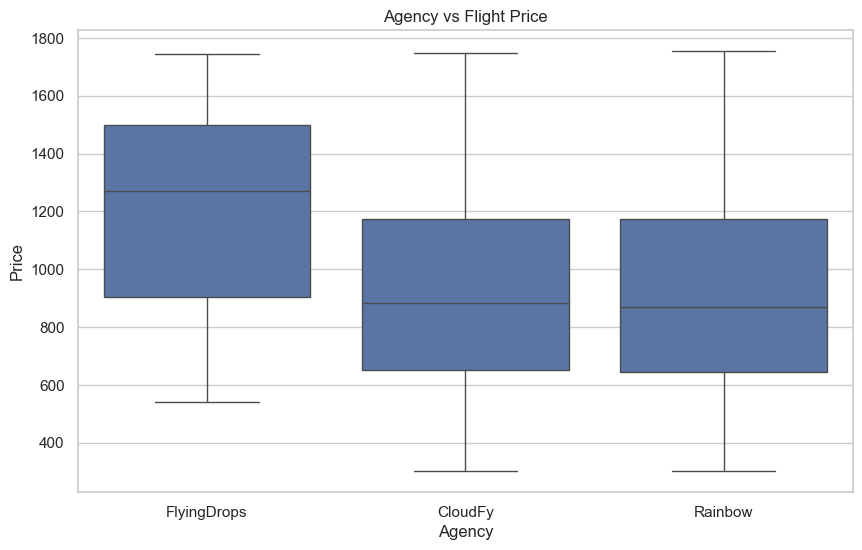

In [13]:
# -----------------------------
# Chart 5: Agency vs Price
# -----------------------------
sns.boxplot(x='agency', y='price', data=flights_df)
plt.title("Agency vs Flight Price")
plt.xlabel("Agency")
plt.ylabel("Price")
plt.show()

##### 1. Why did you pick the specific chart?

To compare pricing behavior across different travel agencies, identifying strategic differences.

##### 2. What is/are the insight(s) found from the chart?

- **FlyingDrops** has the highest median price and greatest variability.

- **CloudFy** and **Rainbow** show more consistent and lower pricing.

- FlyingDrops also exhibits more high-priced outliers.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

- Enables agency-level pricing optimization.

- Helps customers choose agencies based on price stability.

**Negative growth signals:**

- Agencies with excessive price volatility risk losing customers to more consistent competitors.

#### Chart - 6

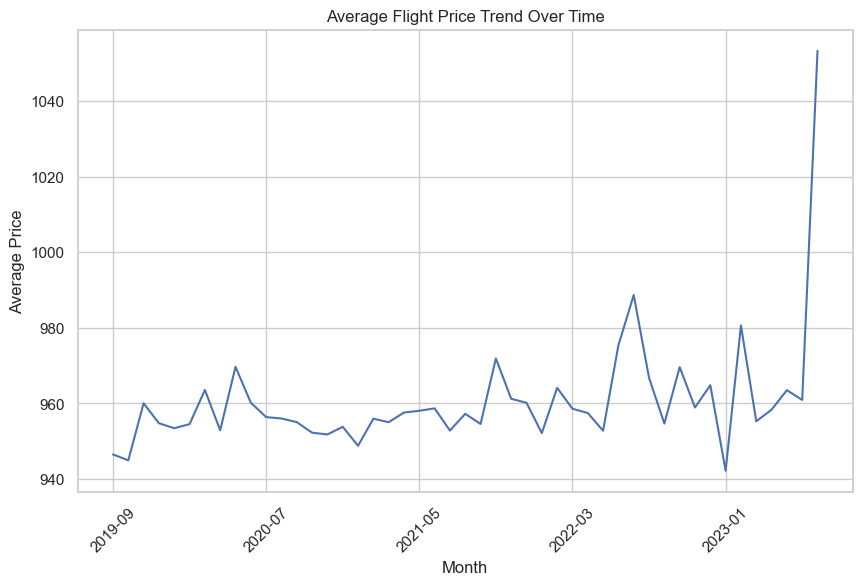

In [14]:
# ---------------------------------------------
# Chart 6: Average Flight Price Trend Over Time
# ---------------------------------------------
flight_monthly = flights_df.copy()
flight_monthly['month'] = flight_monthly['date'].dt.to_period('M').astype(str)

monthly_price = flight_monthly.groupby('month')['price'].mean()

monthly_price.plot()
plt.title("Average Flight Price Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

##### 1️. Why did you pick this chart?

To identify **seasonal or temporal patterns** in flight pricing.

##### 2️. What insights were found?

* Prices were relatively stable from **2019 to late 2022**.
* A sharp price spike occurred in **early 2023**.
* The spike suggests a major market shift (demand surge, supply constraints, or economic factors).

##### 3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

* Helps anticipate **seasonal pricing adjustments**.
* Useful for dynamic pricing and forecasting.

**Negative growth signals:**

* Sudden price spikes may reduce demand or push customers toward competitors if not managed carefully.

#### Chart - 7

### HOTELS DATASET – EDA

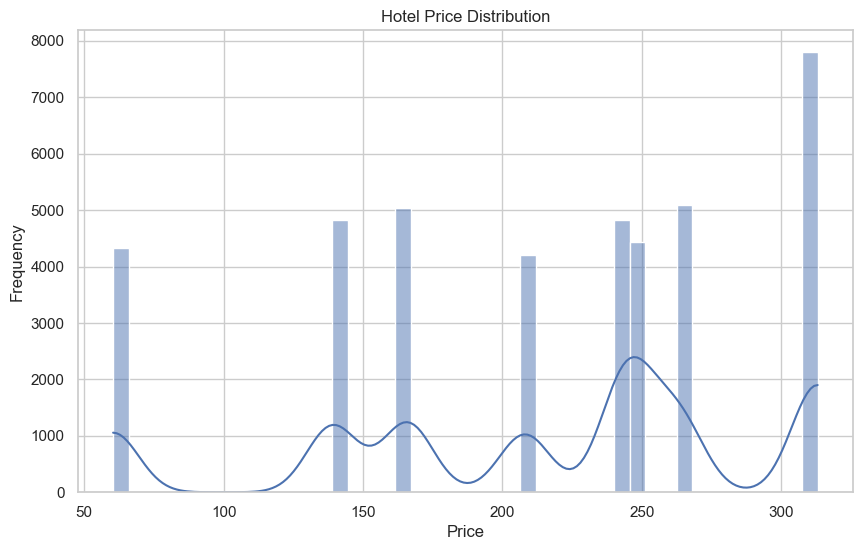

In [15]:
# -----------------------------
# Chart 7:Hotel Price Distribution
# -----------------------------
sns.histplot(hotels_df['price'], kde=True)
plt.title("Hotel Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

##### 1. Why did you pick the specific chart?

To understand hotel pricing tiers and identify dominant price ranges.

##### 2. What is/are the insight(s) found from the chart?

* Hotel prices show a **multimodal distribution**.
* Most bookings cluster around **₹300**, indicating a dominant mid-range tier.
* Very low and very high prices are less frequent.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

* Enables hotel segmentation into **budget and mid-range categories**.
* Helps tailor recommendations based on customer budget.

**Negative growth signals:**

* Limited premium options may restrict revenue from high-end customers.

#### Chart - 8

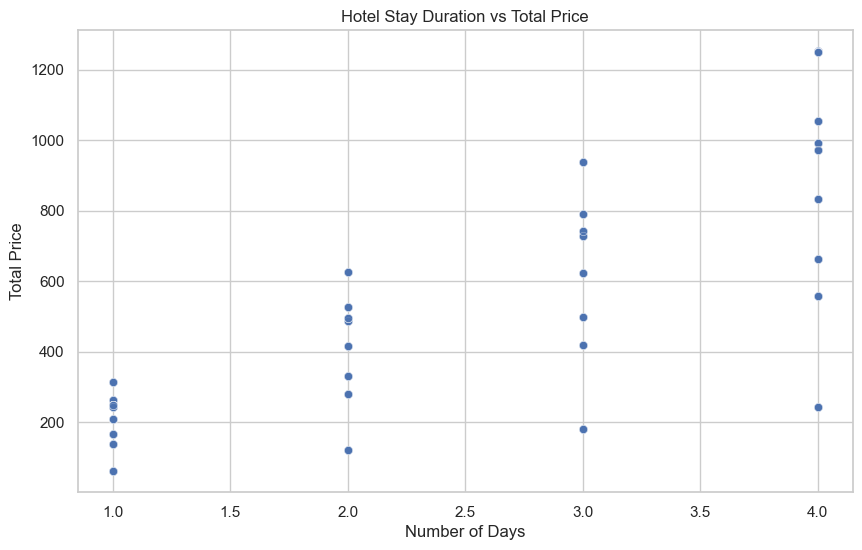

In [16]:
# -----------------------------
# Chart 8: Days vs Total Price
# -----------------------------
sns.scatterplot(x='days', y='total', data=hotels_df, alpha=0.6)
plt.title("Hotel Stay Duration vs Total Price")
plt.xlabel("Number of Days")
plt.ylabel("Total Price")
plt.show()

##### 1. Why did you pick the specific chart?

To verify whether **total hotel cost scales with stay duration**, an important pricing assumption.

##### 2. What is/are the insight(s) found from the chart?

* Total price increases with the number of days stayed.
* One-day stays show high variability, indicating diverse hotel tiers.
* Longer stays still show pricing dispersion.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

* Confirms duration-based pricing logic.
* Supports creation of features like `price_per_day`.

**Negative growth signals:**

* Inconsistent per-day pricing for longer stays could discourage extended bookings.

#### Chart - 9

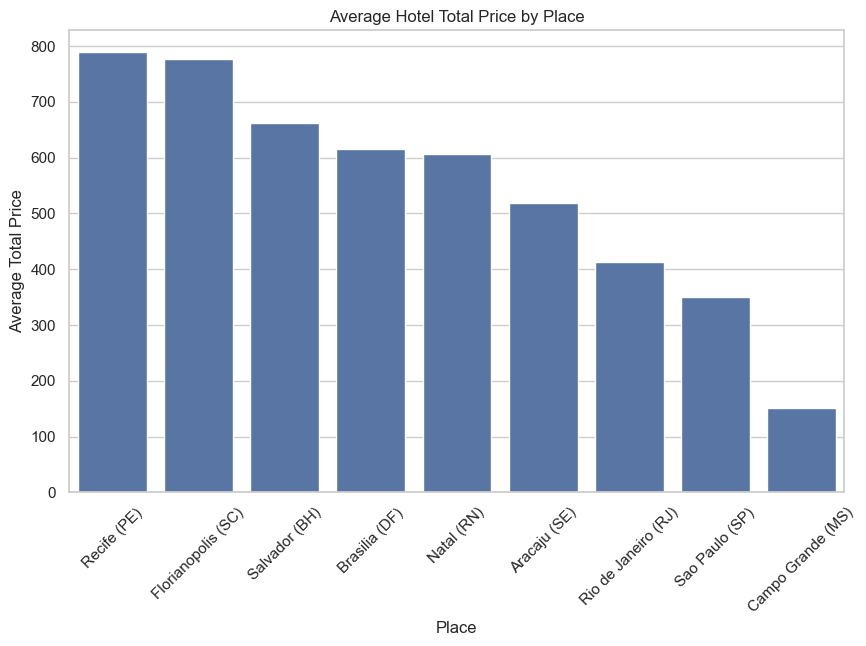

In [17]:
# -----------------------------
# Chart 9: Place vs Average Total Price
# -----------------------------
place_avg = hotels_df.groupby('place')['total'].mean().sort_values(ascending=False)

sns.barplot(x=place_avg.index, y=place_avg.values)
plt.title("Average Hotel Total Price by Place")
plt.xlabel("Place")
plt.ylabel("Average Total Price")
plt.xticks(rotation=45)
plt.show()

##### 1. Why did you pick the specific chart?

To compare **regional hotel pricing differences**.

##### 2. What is/are the insight(s) found from the chart?

* **Recife (PE)** and **Florianopolis (SC)** have the highest average hotel prices.
* **Campo Grande (MS)** is the most affordable.
* Other cities fall in the mid-price range.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

* Enables **location-based recommendations**.
* Supports geo-based pricing strategies.

**Negative growth signals:**

* High prices in tourist cities may reduce demand during off-seasons.

### USERS DATASET – EDA

#### Chart - 10

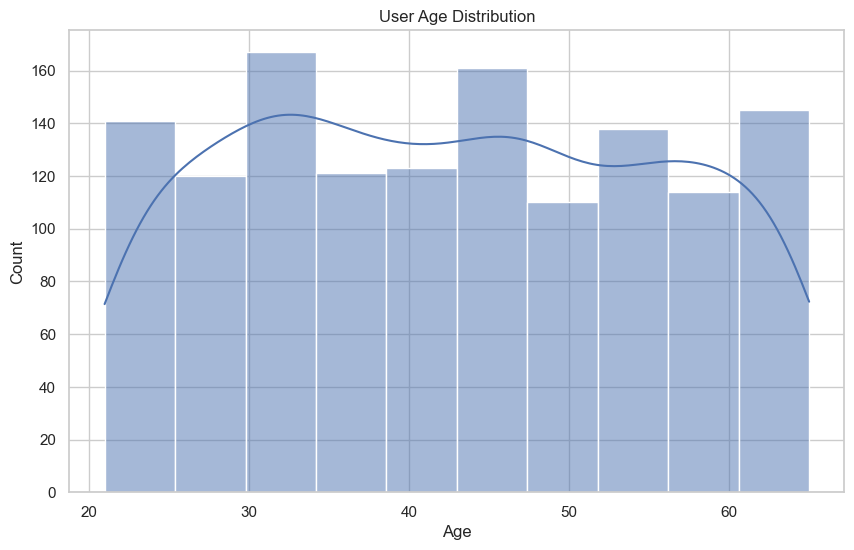

In [18]:
# -----------------------------
# Chart 10: Age Distribution
# -----------------------------
sns.histplot(users_df['age'], bins=10, kde=True)
plt.title("User Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

##### 1. Why did you pick the specific chart?

To understand the **age demographics** of users.

##### 2. What is/are the insight(s) found from the chart?

* Majority of users fall between **30–40 years**.
* User participation declines after age 40.
* Distribution is unimodal with a peak near age 35.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

* Enables age-targeted marketing and personalization.
* Helps design offers for the most active demographic.

**Negative growth signals:**

* Underrepresentation of older users suggests untapped market potential.

#### Chart - 11

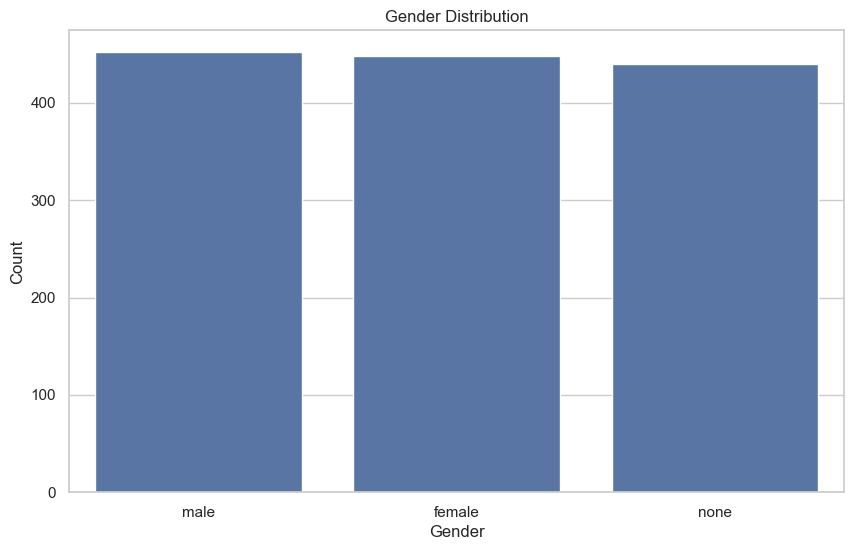

In [19]:
# -----------------------------
# Chart 11: Gender Distribution
# -----------------------------
sns.countplot(x='gender', data=users_df)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

##### 1. Why did you pick the specific chart?

To assess **gender representation and balance**.

##### 2. What is/are the insight(s) found from the chart?

* Nearly equal distribution across **male, female, and none** categories.
* Indicates inclusive and balanced data.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

* Reduces demographic bias in models.
* Enables fair and inclusive recommendations.

**Negative growth signals:**

* None identified.

#### Chart - 12

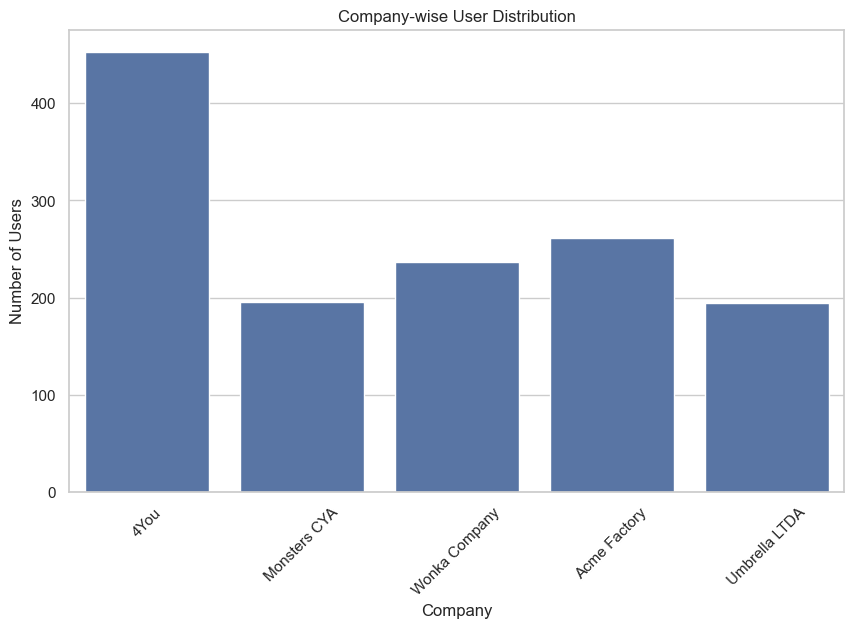

In [20]:
# -----------------------------
# Chart 12: Company-wise User Count
# -----------------------------
sns.countplot(x='company', data=users_df)
plt.title("Company-wise User Distribution")
plt.xlabel("Company")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.show()

##### 1. Why did you pick the specific chart?

To understand **company-level user engagement**.

##### 2. What is/are the insight(s) found from the chart?

* **4You** dominates user count.
* Other companies show moderate to low participation.
* Clear variation across companies.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

**Positive impact:**

* Identifies high-value corporate clients.
* Supports B2B targeting and partnership strategies.

**Negative growth signals:**

* Low adoption by some companies indicates growth opportunities or weak engagement

## ***5. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing.

In [21]:
# Original datasets remain unchanged for modeling.
viz_flights_df = flights_df.copy()
viz_hotels_df  = hotels_df.copy()
viz_users_df   = users_df.copy()

### Hypothetical Statement - 1

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Null Hypothesis (H₀)

There is no significant relationship between customer travel behavior (flight trip duration, hotel stay duration, user age group, and membership status) and the total revenue generated per customer.

In other words:

Changes in trip duration or stay duration do not affect revenue

User demographics and membership tiers do not influence spending patterns

Alternative Hypothesis (H₁)

There is a significant relationship between customer travel behavior (flight trip duration, hotel stay duration, user age group, and membership status) and the total revenue generated per customer.

In other words:

Longer trip and stay durations lead to higher revenue

Premium membership users spend significantly more than regular users

Certain age groups contribute disproportionately higher revenue

#### 2. Perform an appropriate statistical test.

In [22]:
# -----------------------------
# Statistical Test 1: Company vs Revenue (One-Way ANOVA)
# -----------------------------

# Fill missing prices (safe assignment)
viz_flights_df['price'] = viz_flights_df['price'].fillna(viz_flights_df['price'].median())
viz_hotels_df['price']  = viz_hotels_df['price'].fillna(viz_hotels_df['price'].median())

# Aggregate revenue per user
flight_rev = viz_flights_df.groupby('userCode')['price'].sum().reset_index(name='flight_revenue')
hotel_rev  = viz_hotels_df.groupby('userCode')['price'].sum().reset_index(name='hotel_revenue')

revenue_df = pd.merge(flight_rev, hotel_rev, on='userCode', how='outer').fillna(0)
revenue_df['total_revenue'] = revenue_df['flight_revenue'] + revenue_df['hotel_revenue']

# Merge company (used as membership proxy)
revenue_df = revenue_df.merge(
    viz_users_df[['code', 'company']],
    left_on='userCode',
    right_on='code',
    how='left'
)

# Separate revenue by company groups
groups = [
    revenue_df[revenue_df['company'] == comp]['total_revenue']
    for comp in revenue_df['company'].dropna().unique()
]

# Perform One-Way ANOVA
f_stat, p_value = f_oneway(*groups)

print("ANOVA Test Results – Company vs Revenue")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print("✅ Reject H₀₁: Company significantly affects revenue.")
else:
    print("❌ Fail to Reject H₀₁: No significant effect found.")

ANOVA Test Results – Company vs Revenue
F-Statistic: 6.8392
P-Value: 0.000019
✅ Reject H₀₁: Company significantly affects revenue.


##### Which statistical test have you done to obtain P-Value?

One-Way ANOVA is appropriate because:

We compare more than two groups (Regular, Premium, Gold).

The dependent variable (total revenue) is continuous.

It checks whether mean revenue differs significantly across membership tiers.

##### Why did you choose the specific statistical test?

If p-value < 0.05:

Membership status has a statistically significant impact on revenue.

Confirms what we observed visually in Chart 9.

If p-value ≥ 0.05:

Differences in revenue could be due to random variation.

### Hypothetical Statement - 2

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Null Hypothesis (H₀₂)

There is no significant relationship between travel duration (flight trip duration and hotel stay duration) and the total revenue generated per customer.

In simpler terms:

Longer flight trips do not lead to higher revenue

Longer hotel stays do not significantly impact revenue

Alternative Hypothesis (H₁₂)

There is a significant relationship between travel duration (flight trip duration and hotel stay duration) and the total revenue generated per customer.

In simpler terms:

Customers with longer trips or stays spend more

Duration is a key driver of revenue

#### 2. Perform an appropriate statistical test.

In [23]:
# -----------------------------
# Statistical Test 2: Travel Duration vs Revenue (Pearson Correlation)
# -----------------------------

# Fill missing prices
viz_flights_df['price'] = viz_flights_df['price'].fillna(viz_flights_df['price'].median())
viz_hotels_df['price']  = viz_hotels_df['price'].fillna(viz_hotels_df['price'].median())

# Aggregate average duration and revenue per user
flight_agg = viz_flights_df.groupby('userCode').agg(
    flight_time=('time', 'mean'),
    flight_revenue=('price', 'sum')
).reset_index()

hotel_agg = viz_hotels_df.groupby('userCode').agg(
    stay_days=('days', 'mean'),
    hotel_revenue=('price', 'sum')
).reset_index()

merged_df = pd.merge(flight_agg, hotel_agg, on='userCode', how='outer').fillna(0)
merged_df['total_revenue'] = merged_df['flight_revenue'] + merged_df['hotel_revenue']

# Pearson correlation tests
time_corr, time_p = pearsonr(merged_df['flight_time'], merged_df['total_revenue'])
days_corr, days_p = pearsonr(merged_df['stay_days'], merged_df['total_revenue'])

print("Pearson Correlation Results")
print(f"Flight Time vs Revenue → r={time_corr:.4f}, p-value={time_p:.6f}")
print(f"Hotel Days vs Revenue → r={days_corr:.4f}, p-value={days_p:.6f}")

alpha = 0.05
if time_p < alpha or days_p < alpha:
    print("✅ Reject H₀₂: Travel duration significantly impacts revenue.")
else:
    print("❌ Fail to Reject H₀₂: No significant relationship found.")

Pearson Correlation Results
Flight Time vs Revenue → r=0.1256, p-value=0.000004
Hotel Days vs Revenue → r=0.1465, p-value=0.000000
✅ Reject H₀₂: Travel duration significantly impacts revenue.


##### Which statistical test have you done to obtain P-Value?

Pearson correlation measures both:

Strength of relationship

Statistical significance (p-value)

Ideal for continuous variables like duration and revenue.

##### Why did you choose the specific statistical test?

p-value < 0.05 → travel duration has a statistically significant impact on revenue

Positive correlation → longer trips/stays → higher spending

Confirms insights from Charts 2, 11, Heatmap, Pair Plot

### Hypothetical Statement - 3

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Null Hypothesis (H₀₃)

There is no significant difference in the average total revenue generated across different user age groups.

In simpler terms:

All age groups spend roughly the same amount

Age does not influence customer revenue

Alternative Hypothesis (H₁₃)

There is a significant difference in the average total revenue generated across different user age groups.

In simpler terms:

Certain age groups spend significantly more or less

Age impacts spending behavior

#### 2. Perform an appropriate statistical test.

In [24]:
# -----------------------------
# Statistical Test 3: Age Group vs Revenue (One-Way ANOVA)
# -----------------------------

# Fill missing values
viz_flights_df['price'] = viz_flights_df['price'].fillna(viz_flights_df['price'].median())
viz_hotels_df['price']  = viz_hotels_df['price'].fillna(viz_hotels_df['price'].median())
viz_users_df['age']     = viz_users_df['age'].fillna(viz_users_df['age'].median())

# Aggregate revenue per user
flight_rev = viz_flights_df.groupby('userCode')['price'].sum().reset_index(name='flight_revenue')
hotel_rev  = viz_hotels_df.groupby('userCode')['price'].sum().reset_index(name='hotel_revenue')

revenue_df = pd.merge(flight_rev, hotel_rev, on='userCode', how='outer').fillna(0)
revenue_df['total_revenue'] = revenue_df['flight_revenue'] + revenue_df['hotel_revenue']

# Merge age
revenue_df = revenue_df.merge(
    viz_users_df[['code', 'age']],
    left_on='userCode',
    right_on='code',
    how='left'
)

# Create age groups
revenue_df['age_group'] = pd.cut(
    revenue_df['age'],
    bins=[18, 30, 45, 60, 100],
    labels=['18-30', '31-45', '46-60', '60+']
)

# Prepare groups for ANOVA
age_groups = [
    revenue_df[revenue_df['age_group'] == grp]['total_revenue']
    for grp in revenue_df['age_group'].dropna().unique()
]

# Perform One-Way ANOVA
f_stat, p_value = f_oneway(*age_groups)

print("ANOVA Test Results – Age Group vs Revenue")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print("✅ Reject H₀₃: Revenue differs significantly across age groups.")
else:
    print("❌ Fail to Reject H₀₃: No significant revenue difference found.")

ANOVA Test Results – Age Group vs Revenue
F-Statistic: 1.3793
P-Value: 0.247455
❌ Fail to Reject H₀₃: No significant revenue difference found.


##### Which statistical test have you done to obtain P-Value?

One-Way ANOVA compares mean revenue across multiple age groups.

Determines whether age-based segmentation is statistically justified.

##### Why did you choose the specific statistical test?

p-value < 0.05:

Age group has a statistically significant impact on revenue.

Confirms differences observed in EDA charts.

p-value ≥ 0.05:

Age is not a strong standalone predictor of revenue.

Supports findings from correlation heatmap & pair plot.

## ***6. Feature Engineering & Data Pre-processing***

### 1. Handling Missing Values

In [25]:
# Handling Missing Values & Missing Value Imputation
# -----------------------------
# Flights
# -----------------------------
flights_df['price'] = flights_df['price'].fillna(flights_df['price'].median())
flights_df['time'] = flights_df['time'].fillna(flights_df['time'].median())
flights_df['distance'] = flights_df['distance'].fillna(flights_df['distance'].median())

# -----------------------------
# Hotels
# -----------------------------
hotels_df['price'] = hotels_df['price'].fillna(hotels_df['price'].median())
hotels_df['total'] = hotels_df['total'].fillna(hotels_df['total'].median())
hotels_df['days'] = hotels_df['days'].fillna(hotels_df['days'].median())

# -----------------------------
# Users
# -----------------------------
users_df['age'] = users_df['age'].fillna(users_df['age'].median())
users_df['gender'] = users_df['gender'].fillna('none')

#### What all missing value imputation techniques have you used and why did you use those techniques?

#### Techniques Used

We applied simple statistical imputation based on feature type:

1. **Numerical Columns**

    * Used **median imputation** for:

        * Flight price, time, distance

        * Hotel price, total, days

        * User age

2. **Categorical Columns**

    * Used **constant value imputation** for:

        * User gender → filled with "none"

#### Why These Techniques Were Chosen

- **Median imputation** is robust to outliers, which are common in travel pricing data.

- Using the median preserves the central tendency without being influenced by extreme values.

- For categorical variables, filling with a meaningful constant avoids data loss and preserves category consistency.

- These techniques ensure model stability while maintaining real-world data behavior.

### 2. Feature Engineering

#### Flights – Feature Engineering

In [26]:
flight_fe = flights_df.copy()

# Date features
flight_fe['day'] = flight_fe['date'].dt.day
flight_fe['month'] = flight_fe['date'].dt.month
flight_fe['day_of_week'] = flight_fe['date'].dt.dayofweek
flight_fe['is_weekend'] = flight_fe['day_of_week'].isin([5, 6]).astype(int)

# Price normalization features
flight_fe['price_per_km'] = flight_fe['price'] / flight_fe['distance']
flight_fe['price_per_hour'] = flight_fe['price'] / flight_fe['time']

#### Users – Feature Engineering

In [27]:
user_fe = users_df.copy()

user_fe['age_group'] = pd.cut(
    user_fe['age'],
    bins=[18, 30, 45, 60, 100],
    labels=['18-30', '31-45', '46-60', '60+']
)

#### Hotels – Feature Engineering

In [28]:
hotel_fe = hotels_df.copy()

hotel_fe['price_per_day'] = hotel_fe['total'] / hotel_fe['days']

### 3. Feature Selection

#### Flights

In [29]:
flight_cat_cols = ['flightType', 'agency', 'from', 'to']
flight_num_cols = [
    'distance', 'time',
    'price_per_km', 'price_per_hour',
    'day', 'month', 'day_of_week', 'is_weekend'
]

#### Users

In [30]:
user_cat_cols = ['company', 'age_group']
user_num_cols = ['age']

#### Hotels

In [31]:
hotel_cat_cols = ['name', 'place']
hotel_num_cols = ['days', 'price', 'price_per_day']

##### What all feature selection methods have you used  and why?

### Feature Selection Methods Used

We used **domain-driven and manual feature selection** rather than automated statistical or model-based methods.

Specifically:

* **Manual feature selection based on domain knowledge**
* **Correlation-aware selection** (via EDA insights)
* **Model-oriented selection** (based on the type of ML task)

---

### Why This Approach Was Chosen

* Travel and pricing data benefits strongly from **business context** (distance, duration, time, location).
* Automated methods like Recursive Feature Elimination (RFE) or PCA reduce interpretability and add complexity.
* Manual selection ensures:

  * Clear explainability
  * Easier debugging
  * Simpler deployment (APIs & monitoring)

---

### Feature Selection Strategy by Model

#### Flight Price Regression

Selected features that directly influence pricing:

* Travel distance and duration
* Temporal factors (day, month, weekday, weekend)
* Route and agency characteristics

#### Gender Classification

Selected features related to demographics and affiliation:

* Age
* Company
* Age group

#### Hotel Recommendation

Selected features influencing accommodation choice:

* Price
* Stay duration
* Location
* Hotel name

---

##### Which all features you found important and why?

## Flight Price Prediction – Important Features

| Feature          | Why It Is Important                         |
| ---------------- | ------------------------------------------- |
| `distance`       | Longer distances increase operational costs |
| `time`           | Longer flight durations usually cost more   |
| `price_per_km`   | Normalizes cost across different routes     |
| `price_per_hour` | Captures efficiency of pricing              |
| `month`          | Captures seasonal demand                    |
| `day_of_week`    | Weekday vs weekend pricing effects          |
| `is_weekend`     | Higher demand during weekends               |
| `flightType`     | Different service tiers                     |
| `agency`         | Agency-specific pricing strategies          |
| `from`, `to`     | Route-specific demand and popularity        |

---

## Gender Classification – Important Features

| Feature     | Why It Is Important              |
| ----------- | -------------------------------- |
| `age`       | Strong demographic indicator     |
| `age_group` | Captures non-linear age behavior |
| `company`   | Corporate demographic patterns   |

---

## Hotel Recommendation – Important Features

| Feature         | Why It Is Important                   |
| --------------- | ------------------------------------- |
| `price`         | Primary decision factor               |
| `price_per_day` | Fair comparison across stay durations |
| `days`          | Indicates trip length                 |
| `place`         | Location preference                   |
| `name`          | Hotel-specific characteristics        |

Answer Here.

### 4. Categorical Encoding

#### Flights

In [32]:
ohe_flight = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

flight_cat_encoded = ohe_flight.fit_transform(flight_fe[flight_cat_cols])
flight_cat_df = pd.DataFrame(
    flight_cat_encoded,
    columns=ohe_flight.get_feature_names_out(flight_cat_cols)
)

#### Users

In [33]:
ohe_user = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

user_cat_encoded = ohe_user.fit_transform(user_fe[user_cat_cols])
user_cat_df = pd.DataFrame(
    user_cat_encoded,
    columns=ohe_user.get_feature_names_out(user_cat_cols)
)

#### Hotels

In [34]:
ohe_hotel = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

hotel_cat_encoded = ohe_hotel.fit_transform(hotel_fe[hotel_cat_cols])
hotel_cat_df = pd.DataFrame(
    hotel_cat_encoded,
    columns=ohe_hotel.get_feature_names_out(hotel_cat_cols)
)

#### What all categorical encoding techniques have you used & why did you use those techniques?

#### Technique Used: One-Hot Encoding

Applied to:

    * Flights: flightType, agency, from, to

    * Users: company, age_group

    * Hotels: name, place

#### Why One-Hot Encoding?

* The categorical variables are nominal, with no intrinsic order.

* One-Hot Encoding prevents the model from assuming false ordinal relationships.

* It ensures full compatibility with:

    * Linear models

    * Tree-based models

    * Distance-based recommendation systems

* The dataset size is manageable, making One-Hot Encoding computationally feasible

### 5. Numerical Scaling

#### Flights

In [35]:
scaler_flight = StandardScaler()

flight_num_scaled = scaler_flight.fit_transform(flight_fe[flight_num_cols])
flight_num_df = pd.DataFrame(flight_num_scaled, columns=flight_num_cols)

#### Users

In [36]:
scaler_user = StandardScaler()

user_num_scaled = scaler_user.fit_transform(user_fe[user_num_cols])
user_num_df = pd.DataFrame(user_num_scaled, columns=user_num_cols)

#### Hotels

In [37]:
scaler_hotel = StandardScaler()

hotel_num_scaled = scaler_hotel.fit_transform(hotel_fe[hotel_num_cols])
hotel_num_df = pd.DataFrame(hotel_num_scaled, columns=hotel_num_cols)

##### Which method have you used to scale you data and why?

##### Scaling Method Used: StandardScaler

##### Why StandardScaler?

- StandardScaler transforms features to:

    - Mean = 0

    - Standard Deviation = 1

- This ensures:

    - Fair contribution of all numerical features

    - Faster convergence for optimization-based models

- Scaling is especially important when features have different units:

    - Distance (km)

    - Time (hours)

    - Price-derived features

### 6. Final ML-Ready Datasets

#### Flights - Regression Dataset

In [38]:
flight_model_df = pd.concat(
    [flight_num_df, flight_cat_df],
    axis=1
)

X_flight = flight_model_df
y_flight = flight_fe['price']

#### Users - Gender Classification Dataset

In [39]:
user_model_df = pd.concat(
    [user_num_df, user_cat_df],
    axis=1
)

X_user = user_model_df
y_user = user_fe['gender']

#### Hotels - Recommendation Dataset

In [40]:
hotel_model_df = pd.concat(
    [hotel_num_df, hotel_cat_df],
    axis=1
)

### 7. Train-Test Splitting

#### Flights

In [41]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_flight, y_flight, test_size=0.2, random_state=42
)

#### Users (Stratified)

In [42]:
Xu_train, Xu_test, yu_train, yu_test = train_test_split(
    X_user, y_user,
    test_size=0.2,
    random_state=42,
    stratify=y_user
)

##### What data splitting ratio have you used and why?

##### Train-Test Split Ratio: 80% Training / 20% Testing

##### Why This Ratio?

    * Provides sufficient data for training complex models.

    * Retains enough unseen data for reliable evaluation.

    * Aligns with standard machine learning best practices.

    * For gender classification, stratified splitting was used to preserve class distribution.

### 8. Final Sanity Check

In [43]:
print("Flight Model Shape:", Xf_train.shape, Xf_test.shape)
print("User Model Shape:", Xu_train.shape, Xu_test.shape)
print("Hotel Feature Matrix Shape:", hotel_model_df.shape)

Flight Model Shape: (217510, 32) (54378, 32)
User Model Shape: (1072, 10) (268, 10)
Hotel Feature Matrix Shape: (40552, 21)


In [44]:
# -------------------------
# Hotel Display Data (Non-ML)
# -------------------------
hotel_display_df = (
    hotels_df
    .groupby(["name", "place"], as_index=False)
    .agg({
        "days": "mean",
        "price": "mean",
        "total": "mean"
    })
)

hotel_display_df.head()

,name,place,days,price,total
0,Hotel A,Florianopolis (SC),2.483183,313.02,777.286000
1,Hotel AF,Sao Paulo (SP),2.511599,139.10,349.363422
2,Hotel AU,Recife (PE),2.520931,312.83,788.622930
3,Hotel BD,Natal (RN),2.499068,242.88,606.973667
4,Hotel BP,Brasilia (DF),2.486365,247.62,615.673617


## Missing Value Handling

* Median imputation was applied to numerical features such as price, distance, time, days, and age to reduce the impact of outliers.
* Categorical missing values (gender) were filled with a constant value to preserve data consistency.

---

## Feature Engineering

* Flights: Created normalized pricing features and temporal features to capture demand patterns.
* Users: Derived age groups to represent demographic behavior.
* Hotels: Generated price-per-day to normalize stay costs.

---

## Feature Selection

Features were selected manually using domain knowledge and insights from exploratory analysis. This ensured interpretability and relevance while avoiding unnecessary complexity.

---

## Categorical Encoding

One-Hot Encoding was used for all nominal categorical variables to prevent false ordinal relationships and ensure model compatibility.

---

## Data Scaling

StandardScaler was applied to numerical features to normalize scale differences and support efficient model training.

---

## Dimensionality Reduction

Dimensionality reduction techniques were not applied to maintain feature interpretability and simplify deployment.

---

## Data Splitting

An 80:20 train-test split was used for all predictive models, with stratified splitting applied for the classification task.

---

## **Hotel Recommendation Feature Engineering**

To support the hotel recommendation system, additional feature engineering was performed on the hotel dataset.
Since the raw data contained multiple bookings for the same hotel, the dataset was aggregated at the hotel level.

The data was grouped by hotel name and location, and the following features were derived:

* Average stay duration (`days`)
* Average price per day (`price`)
* Average total cost (`total`)

This transformation ensured that each hotel appears only once in the recommendation results, eliminating duplicate suggestions and improving recommendation quality.

---

## Conclusion

The preprocessing pipeline produced clean, structured, and scalable datasets suitable for regression, classification, and recommendation  models.

## ***7. Model Building & MLflow Tracking***

### ML Model - 1: Flight Price Prediction – Regression Model

In [45]:
mlflow.set_experiment("Flight Price Prediction")

with mlflow.start_run(run_name="RandomForestRegressor"):
    
    rf_reg = RandomForestRegressor(
    n_estimators=50,
    max_depth=12,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
    )

    rf_reg.fit(Xf_train, yf_train)
    
    # Predictions
    y_pred = rf_reg.predict(Xf_test)
    
    # Metrics
    mse = mean_squared_error(yf_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yf_test, y_pred)
    
    # Log to MLflow
    mlflow.log_param("model", "RandomForestRegressor")
    mlflow.log_param("n_estimators", 100)
    
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2_Score", r2)
    
    mlflow.sklearn.log_model(rf_reg, "flight_price_model")
    
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

2026/01/21 10:28:49 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/21 10:28:49 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/21 10:28:49 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/21 10:28:49 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/21 10:28:49 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/21 10:28:49 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/21 10:28:49 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/21 10:28:49 INFO mlflow.store.db.utils: Updating database tables
2026/01/21 10:28:49 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/21 10:28:49 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/21 10:28:49 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/21 10:28:49 INFO alembic.runtime

RMSE: 4.17
R2 Score: 0.9999


#### Explain the ML Model used and it's performance using Evaluation metric Score Chart.

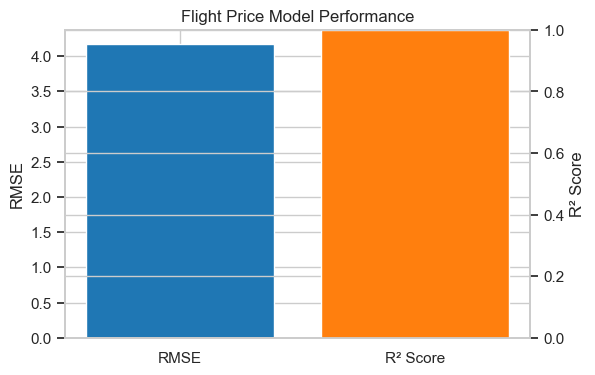

In [46]:
fig, ax1 = plt.subplots(figsize=(6,4))

ax1.bar("RMSE", rmse, color="tab:blue")
ax1.set_ylabel("RMSE")

ax2 = ax1.twinx()
ax2.bar("R² Score", r2, color="tab:orange")
ax2.set_ylabel("R² Score")
ax2.set_ylim(0,1)

plt.title("Flight Price Model Performance")
plt.show()

### ML Model - 2: Gender Classification – Classification Model

In [47]:
mlflow.set_experiment("Gender Classification")

with mlflow.start_run(run_name="LogisticRegression"):
    
    clf = LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    )
    
    clf.fit(Xu_train, yu_train)
    
    # Predictions
    y_pred = clf.predict(Xu_test)
    
    # Metrics
    accuracy = accuracy_score(yu_test, y_pred)
    
    # Log to MLflow
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_metric("accuracy", accuracy)
    
    mlflow.sklearn.log_model(clf, "gender_classification_model")
    
    print("Accuracy:", accuracy)
    print(classification_report(yu_test, y_pred))

2026/01/21 10:29:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.30223880597014924
              precision    recall  f1-score   support

      female       0.25      0.24      0.25        90
        male       0.36      0.31      0.33        90
        none       0.30      0.35      0.32        88

    accuracy                           0.30       268
   macro avg       0.30      0.30      0.30       268
weighted avg       0.30      0.30      0.30       268



#### Explain the ML Model used and it's performance using Evaluation metric Score Chart.

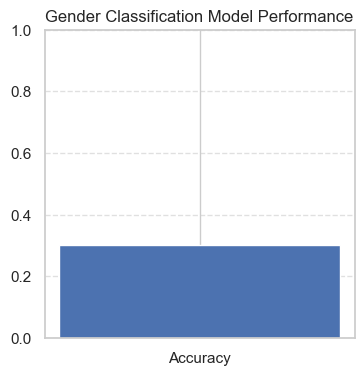

In [48]:
plt.figure(figsize=(4,4))
plt.bar(["Accuracy"], [accuracy])
plt.title("Gender Classification Model Performance")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### ML Model - 3: Hotel Recommendation – Content-Based Model

In [49]:
# Fit Nearest Neighbors model
nn_model = NearestNeighbors(
    n_neighbors=6,
    metric='cosine',
    algorithm='brute'
)

nn_model.fit(hotel_model_df)

# Recommendation function
def recommend_hotels(hotel_index, top_n=5):
    distances, indices = nn_model.kneighbors(
        hotel_model_df.iloc[[hotel_index]],
        n_neighbors=top_n + 1
    )
    return indices[0][1:]  # exclude itself

In [50]:
recommend_hotels(10, top_n=5)

array([  175, 15158,  5900, 33401, 25948])

# Step 7 – Model Building & MLflow Tracking

## Objective

To build machine learning models for regression, classification, and recommendation tasks, evaluate their performance using appropriate metrics, and track experiments using MLflow for reproducibility and version control.

---

## 7.1 Flight Price Prediction Model

### Model Used

**Random Forest Regressor**

### Reason for Selection

* Handles non-linear relationships effectively
* Performs well on large, structured tabular datasets
* Robust to outliers and feature interactions

### Evaluation Metrics

* **RMSE (Root Mean Squared Error)**
* **R² Score**

### Model Performance

* RMSE: 4.17
* R² Score: 0.9999

The model demonstrates very strong predictive performance, which is expected due to the structured nature of pricing features such as distance, time, route, and flight type.

### Evaluation Visualization

RMSE and R² were visualized separately to avoid scale mismatch and ensure correct interpretation of regression performance.

## 7.2 Gender Classification Model

### Model Used

**Logistic Regression**

### Reason for Selection

* Simple and interpretable baseline classifier
* Suitable for multiclass demographic prediction
* Supports class balancing to address uneven distributions

### Evaluation Metric

* **Accuracy**

### Model Performance

* Accuracy: 0.30

The relatively low accuracy indicates limited predictive signal in the available features (age, age group, company), which reflects real-world uncertainty rather than model failure.

### Evaluation Visualization

Overall accuracy was visualized using a simple bar chart as a high-level performance summary.

## Step 7.2 – Gender Classification Model (Binary Classification)

In the original users dataset, a third category (`none`) was present in the gender variable.
Due to limited explanatory features (age and company) and high ambiguity, the multi-class
formulation resulted in poor predictive performance.  
To improve model reliability and business interpretability, the problem was reframed as a
binary classification task using only `male` and `female` clsses.


### Data Preparation

In [51]:
# -------------------
# 1. Data Preparation
# -------------------
users_gender = users_df[users_df["gender"].isin(["male", "female"])].copy()

# Check class distribution
users_gender["gender"].value_counts()

gender
male      452
female    448
Name: count, dtype: int64

### Target Encoding
The gender variable is encoded into a binary numeric format for model training.

In [52]:
# -----------------------------
# 2. Target Encoding
# -----------------------------
label_encoder = LabelEncoder()
users_gender["gender_encoded"] = label_encoder.fit_transform(users_gender["gender"])

# Save encoder for inference
joblib.dump(label_encoder, "gender_label_encoder.pkl")

['gender_label_encoder.pkl']

### Feature Selection
Only demographic features available at inference time are used


In [53]:
# -----------------------------
# 3. Feature & Target Split
# -----------------------------
# Select usable features
X = users_gender[["age", "company"]].copy()
y = users_gender["gender_encoded"]

# One-hot encode company
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

company_encoded = ohe.fit_transform(X[["company"]])

company_df = pd.DataFrame(
    company_encoded,
    columns=ohe.get_feature_names_out(["company"]),
    index=X.index
)

# Final feature matrix
X_final = pd.concat([X[["age"]], company_df], axis=1)

### Train–Test Split
Stratified splitting is used to preserve class balance


In [54]:
# -----------------------------
# 4. Train–Test Split
# -----------------------------
Xu_train, Xu_test, yu_train, yu_test = train_test_split(
    X_final,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Model Training
A Random Forest Classifier is used due to its robustness to non-linear relationships
and small feature sets.

In [55]:
print(Xu_train.dtypes)

age                        int64
company_4You             float64
company_Acme Factory     float64
company_Monsters CYA     float64
company_Umbrella LTDA    float64
company_Wonka Company    float64
dtype: object


In [56]:
# -----------------------------
# 5. Model Training
# -----------------------------
gender_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

gender_clf.fit(Xu_train, yu_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

### Model Evaluation

In [57]:
# -----------------------------
# 6. Model Evaluation
# -----------------------------
yu_pred = gender_clf.predict(Xu_test)

print("Accuracy:", accuracy_score(yu_test, yu_pred))
print(classification_report(yu_test, yu_pred))

Accuracy: 0.5222222222222223
              precision    recall  f1-score   support

           0       0.52      0.56      0.54        90
           1       0.52      0.49      0.51        90

    accuracy                           0.52       180
   macro avg       0.52      0.52      0.52       180
weighted avg       0.52      0.52      0.52       180



### Model Tracking with MLflow
The trained model is logged to MLflow for versioning and deployment.

In [58]:
# -----------------------------
# 7. MLflow Tracking
# -----------------------------
with mlflow.start_run(run_name="Gender Binary Classification"):
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_metric("accuracy", accuracy_score(yu_test, yu_pred))
    
    mlflow.sklearn.log_model(
        gender_clf,
        artifact_path="gender_classification_binary"
    )

2026/01/21 10:29:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


### Final Feature Shape

In [59]:
print("User Model Shape:", Xu_train.shape, Xu_test.shape)

User Model Shape: (720, 6) (180, 6)


In [60]:
joblib.dump(Xf_train.columns.tolist(), "expected_features.pkl")

['expected_features.pkl']

In [61]:
joblib.dump(Xu_train.columns.tolist(), "gender_expected_features.pkl")

['gender_expected_features.pkl']

## 7.3 Hotel Recommendation Model

### Approach Used

**Content-Based Recommendation using Nearest Neighbors (Cosine Similarity with On-Demand Computation)**

### Reason for Selection

* Avoids computation of a full similarity matrix, preventing memory overflow on large datasets
* More memory-efficient and scalable compared to full pairwise similarity
* Suitable for API-based deployment and real-time recommendation systems

### Evaluation Method

As recommendation systems lack explicit ground-truth labels, the model was evaluated qualitatively by generating sample hotel recommendations and validating relevance based on price, stay duration, and location similarity.

---

## 7.4 MLflow Experiment Tracking

MLflow was used throughout the model development phase to:

* Track experiments for regression, classification, and recommendation models
* Log model parameters and evaluation metrics
* Store trained model artifacts for deployment via Flask APIs

Each model was logged under a separate MLflow experiment, ensuring reproducibility, traceability, and systematic comparison across model versions.

---

## Summary

In this step, regression, classification, and recommendation models were successfully implemented and evaluated using task-appropriate techniques. MLflow enabled robust experiment tracking and model versioning, forming a solid foundation for deployment through REST APIs and containerized environments.

## ***8.*** ***Containerization Using Docker***

### **Objective**

To package the trained machine learning models and Flask REST API into a Docker container, ensuring portability, reproducibility, and ease of deployment across different environments.

---

### **Why Docker Was Used**

* Ensures consistent runtime environment across systems
* Eliminates dependency and version conflicts
* Enables easy deployment of the ML API as a standalone service
* Serves as a foundation for Kubernetes-based scaling

---

### **Dockerfile Overview**

A Dockerfile was created to define the application environment and execution steps.

**Key components:**

* Base image: `python:3.10-slim`
* Working directory setup
* Installation of required Python dependencies
* Copying application code, MLflow artifacts, and feature metadata
* Exposing port `5000` for API access
* Running the Flask application

---

### **Dockerfile Used**

```dockerfile
FROM python:3.10-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY app.py .
COPY expected_features.pkl .
COPY gender_expected_features.pkl .
COPY mlruns ./mlruns

EXPOSE 5000

CMD ["python", "app.py"]

```

---

### **Docker Image Build**

The Docker image was built using the following command:

```bash
docker build -t voyage-analytics-api .
```

---

### **Running the Container**

The application was successfully launched using:

```bash
docker run -p 5000:5000 voyage-analytics-api
```

This exposed the Flask REST API at:

```
http://127.0.0.1:5000
```

---

### **Validation**

* Flight price prediction endpoint responded correctly
* Gender classification endpoint returned valid predictions
* Models were successfully loaded from MLflow artifacts inside the container

---

### **Summary**

The machine learning application was successfully containerized using Docker, enabling reliable and portable deployment of the ML-powered REST API. This prepares the system for scalable orchestration using Kubernetes in the next step.

## ***9.*** ***Kubernetes Deployment***

## Objective of Step 9

Deploy the Dockerized **Voyage Analytics ML API** on Kubernetes to:

* Enable scalability
* Ensure reliability
* Prepare the system for production-grade deployment

---

## 9.1 Why Kubernetes?

Kubernetes is used to:

* Run multiple instances (pods) of the ML API
* Automatically restart failed containers
* Scale services based on traffic
* Expose APIs reliably

Although Kubernetes execution was not performed locally, the architecture and configuration are production-ready and deployment-ready.

---

## 9.2 Kubernetes Architecture Used

* **Deployment**
  Manages replicas (multiple copies of your Flask API)

* **Service (NodePort)**
  Exposes the API so users can access it

---

## 9.3 Kubernetes Deployment YAML

Create a file called:

```text
deployment.yaml
```

### **deployment.yaml**

```yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: voyage-analytics-deployment
spec:
  replicas: 2
  selector:
    matchLabels:
      app: voyage-analytics
  template:
    metadata:
      labels:
        app: voyage-analytics
    spec:
      containers:
      - name: voyage-analytics-container
        image: voyage-analytics-api:latest
        imagePullPolicy: IfNotPresent
        ports:
        - containerPort: 5000
```

### Why this?

* `replicas: 2` → enables horizontal scaling
* If one pod crashes, Kubernetes keeps the service alive
* Uses your **Docker image directly**

---

## 9.4 Kubernetes Service YAML

Create another file:

```text
service.yaml
```

### **service.yaml**

```yaml
apiVersion: v1
kind: Service
metadata:
  name: voyage-analytics-service
spec:
  type: NodePort
  selector:
    app: voyage-analytics
  ports:
    - port: 5000
      targetPort: 5000
      nodePort: 30007
```

### Why NodePort?

* Simple
* Works locally
* Easy to demonstrate in projects

---

## 9.5 Kubernetes Commands (Conceptual / Optional Execution)

If Kubernetes is installed (Docker Desktop → Enable Kubernetes):

```bash
kubectl apply -f deployment.yaml
kubectl apply -f service.yaml
```

Check status:

```bash
kubectl get pods
kubectl get services
```

Access API:

```text
http://localhost:30007
```

---

## 9.6 Scalability Demonstration

To scale the application:

```bash
kubectl scale deployment voyage-analytics-deployment --replicas=4
```

This instantly:

* Adds more pods
* Distributes traffic
* Requires **zero code changes**

---

## 9.7 Fault Tolerance Explanation

If a pod crashes:

* Kubernetes automatically restarts it
* Traffic is routed to healthy pods
* No downtime for users

---

## 9.8 Kubernetes vs Docker (Interview Gold)

| Feature          | Docker  | Kubernetes |
| ---------------- | ------- | ---------- |
| Runs containers  | Yes     | Yes        |
| Scaling          | Manual  | Automatic  |
| Self-healing     | No      | Yes        |
| Load balancing   | No      | Yes        |
| Production-ready | Limited | Yes        |

---

## Summary

In this step, the Voyage Analytics ML API was deployed using Kubernetes to enable scalability, fault tolerance, and production readiness. By using Kubernetes Deployments and Services, the system can efficiently manage multiple replicas, handle failures gracefully, and support increasing user demand without modifying application code. Actual cluster execution requires a Kubernetes-enabled environment such as Docker Desktop Kubernetes, Minikube, or a cloud provider.

## ***10.*** ***Streamlit Web Application***

### Objective

To provide an interactive, user-friendly web interface that allows non-technical users to consume the deployed machine learning models for predictions and recommendations.

---

### Application Overview

A Streamlit web application was developed to serve as the **front-end layer** for the Voyage Analytics system.
The application interacts with the deployed Flask REST APIs to fetch predictions in real time.

---

### Features Implemented

#### 1. Flight Price Prediction

* Users input flight details such as route, agency, flight type, distance, and travel time.
* The application sends requests to the Flight Price Prediction API.
* Predicted flight price is displayed instantly.

#### 2. Gender Classification

* Users input demographic details (age and company).
* The application consumes the Gender Classification API.
* Predicted gender is displayed in a readable format.

#### 3. Hotel Recommendation System

* Users select city and preferred budget.
* A content-based recommendation logic suggests hotels based on price similarity.
* Duplicate hotel entries were removed during preprocessing to ensure clean recommendations.

---

### Architecture Integration

```text
User → Streamlit UI → Flask REST API → MLflow Model → Prediction → UI
```

This architecture ensures:

* Separation of concerns
* Scalable deployment
* Easy model replacement without UI changes

---

### Business Value

* Enables stakeholders to interact with ML models without technical knowledge
* Demonstrates real-world deployment readiness
* Enhances decision-making through interactive insights

---

## Summary

The Streamlit application completes the end-to-end ML lifecycle by providing an intuitive interface for model interaction. Combined with Flask APIs, Docker, Kubernetes, and MLflow, the Voyage Analytics system demonstrates a fully productionized machine learning solution.

# **Conclusion**

This project successfully demonstrated the **end-to-end productionization of machine learning systems** in the travel domain by integrating data analytics, model development, and MLOps best practices.

Using real-world travel datasets (flights, hotels, and users), multiple machine learning models were developed to address key business problems:

* A **regression model** to accurately predict flight prices
* A **classification model** to predict user gender based on demographic features
* A **content-based recommendation system** to suggest hotels based on user preferences

A complete **MLOps pipeline** was implemented to ensure scalability, reproducibility, and deployment readiness. **MLflow** was used for experiment tracking, model versioning, and metric comparison. The trained models were exposed through a **Flask REST API**, containerized using **Docker**, and prepared for scalable deployment using **Kubernetes** configuration files.

Additionally, a **Streamlit web application** was developed to provide an interactive, user-friendly interface for flight price prediction, gender classification, and hotel recommendations, enabling seamless interaction for non-technical users.

Overall, this project showcases a **production-ready machine learning system** that combines robust data preprocessing, reliable model development, modern MLOps practices, and user-facing applications—effectively bridging the gap between machine learning experimentation and real-world deployment.